## Building stacked lensing profile including effects of triaxiality.
### Zhuowen Zhang
#### Updated Sept. 4 2018

In [1]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir
import pyfits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/redM_Buzzard/'
ds_tplt_dir = home_dir()+'output/deltasigma/'
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param

### Import Halo File

In [2]:
#Miscentering cut
import pickle

redM_halos = homedir + 'output/buzzard/redM_halos_fullmatchingparams_matchingv1.2_Buzzardv1.6.data'

infile = open(redM_halos,'rb')
redM_halos = pickle.load(infile)
infile.close()

redM_halos = redM_halos.view(np.recarray)
print redM_halos.dtype
print len(redM_halos)

(numpy.record, [('GALAXY_ID', '>i4'), ('HALOID', '>i4'), ('DESCID', '>i8'), ('RA_OBS', '>f8'), ('DEC_OBS', '>f8'), ('TRA', '>f8'), ('TDEC', '>f8'), ('Z', '>f8'), ('MVIR', '>f8'), ('VMAX', '>f8'), ('VRMS', '>f8'), ('RVIR', '>f8'), ('RS', '>f8'), ('NP', '>f8'), ('PX', '>f8'), ('PY', '>f8'), ('PZ', '>f8'), ('VX', '>f8'), ('VY', '>f8'), ('VZ', '>f8'), ('JX', '>f8'), ('JY', '>f8'), ('JZ', '>f8'), ('SPIN', '>f8'), ('RS_KLYPIN', '>f8'), ('MVIR_ALL', '>f8'), ('M200B', '>f8'), ('M200C', '>f8'), ('M500C', '>f8'), ('M2500C', '>f8'), ('XOFF', '>f8'), ('VOFF', '>f8'), ('SPIN_BULLOCK', '>f8'), ('B_TO_A', '>f8'), ('C_TO_A', '>f8'), ('PID', '>i8'), ('LUMTOT', '>f8'), ('LUM20', '>f8'), ('LBCG', '>f8'), ('NGALS', '>i8'), ('N18', '>i8'), ('N19', '>i8'), ('N20', '>i8'), ('N21', '>i8'), ('N22', '>i8'), ('matching_ID', '<i8'), ('MEM_MATCH_ID', '<i8'), ('LAMBDA_CHISQ', '<f8'), ('RA_REDM', '<f8'), ('DEC_REDM', '<f8'), ('q', '<f8'), ('s', '<f8'), ('cosi', '<f8'), ('centered_flag', '<i8')])
13628


In [3]:
from repo.halo_shape.read_shape_param import read_shape_param
halos_M = redM_halos.M200B
haloid = redM_halos.HALOID
halos_RA = redM_halos.RA_OBS
halos_DEC = redM_halos.DEC_OBS
richness = redM_halos.LAMBDA_CHISQ
q = redM_halos.q
s = redM_halos.s
cos_i = redM_halos.cosi

lnl = np.log(richness)
lnM200b = np.log(halos_M)

print "Number of halos is ", len(q)
print "Min/max mass is {0:.2f}, {1:.2f}".format(min(lnM200b), max(lnM200b))
print "{:g}".format(max(halos_M))

Number of halos is  13628
Min/max mass is 29.93, 35.76
3.403e+15


### Bin by cosi and richness

In [4]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind = halo_bin_stat(cos_i, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind = halo_bin_stat(richness, lmda_bins)
lnM_lmda_binned = np.zeros_like(lmda_bins_ind)
lnM_lmda_binned = np.array([np.log(halos_M[lmda_bins_ind[x]]) for x in range(len(lmda_bins_ind))])

#print lnM_lmda_binned
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q))]

Maximum richness after cuts is  303.0442810058594


In [5]:
##Shorthand name for relevant halo/redM parameters
#halos_ID_miscent, q_miscent, s_miscent, cos_i_miscent = read_shape_param(np.array(redM_miscent), convcut=True)
print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_cosi_binned = [None]*num_bins
lnl_cosi_binned = [None]*num_bins

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_cosi_binned[i] = np.log(halos_M[cosi_bins_ind[i]])
    lnl_cosi_binned[i] = np.log(richness[cosi_bins_ind[i]])

Halo mass range is from  13.000564216165376 15.53186194909581


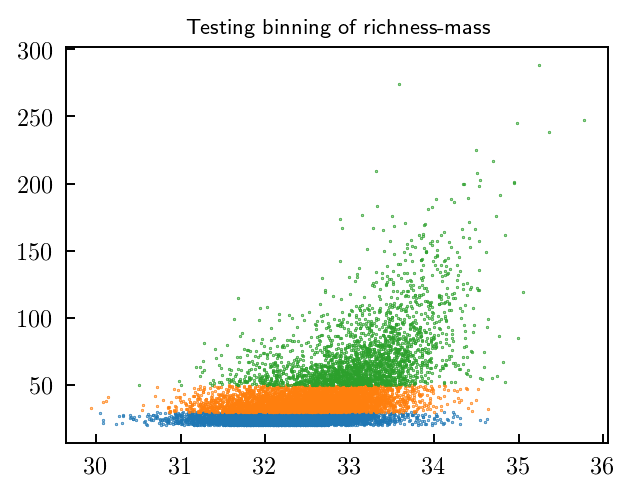

In [6]:
#Check properly binned by reproducing the richness-mass relation
plt.figure(figsize=(4,3))
plt.title(r'Testing binning of richness-mass', fontsize=9)
for i in range(3):
    plt.scatter(lnM_lmda_binned[i], richness[lmda_bins_ind[i]], s=0.1)
    
plt.show()

### Importing functions from DS_functions. These include:

#### 1. Best fit parameters of richness-mass A, B, sig0
Using model3 (vary A only, best fit of B, \sigma found from model2) interpolate lnA using spline with no smoothing.
#### 2. prob_lambda: using best fit params calculates prob of finding lnl given lnM from theoretical prediction. 
#### 3. lnDS_ratio: Heidi's template for orientation dependence of DeltaSigma


In [7]:
from repo.surface_density.DS_functions import interpolate_A, bestfit_A, bestfit_B, bestfit_sig0
from repo.surface_density.DS_functions import prob_lambda
from repo.surface_density.DS_functions import lnDS_ratio


cosi_mid, spl_lnA, data_lnA = interpolate_A(tpltdir, cosi_bins)
allfit_A = bestfit_A(tpltdir)
allfit_B = bestfit_B(tpltdir)
allfit_sig0 = bestfit_sig0(tpltdir)

print "best fit global lnA, B, sig0 are", np.log(allfit_A), allfit_B, allfit_sig0

/home/zzbenjamin94/anaconda2/lib/python2.7/site-packages/chainconsumer/analysis.py:264: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, edges = np.histogram(data, bins=bins, normed=True, weights=chain.weights)


best fit global lnA, B, sig0 are 2.760345718144925 0.8672562498926204 0.4646067757219166


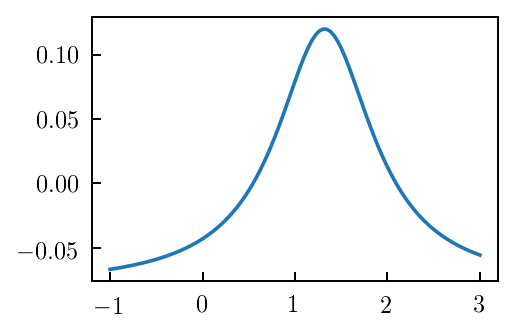

In [8]:
##Teting lnDS_ratio
x = np.linspace(-1,3,100)
lnDS_tplt = lnDS_ratio(0.5,x, z=0.3, m=2e14)

plt.figure(figsize=(3,2))
plt.plot(x, lnDS_tplt)
plt.show()

### Power Spectrum from CLASS
Using the Buzzard cosmology. 

In [9]:
#Build the cosmology
from classy import Class
import numpy as np

#Start by specifying the cosmology
Omega_b = 0.046
Omega_m = 0.286
Omega_cdm = Omega_m - Omega_b
h = 0.70
A_s = 2.1e-9
n_s = 0.96

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc
params = {
             'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

In [10]:
#Initialize the cosmology and compute power spectrum
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k_ps = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1
z = 0.1

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k_ps])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k_ps])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k_ps /= h
Plin *= h**3
Pnonlin *= h**3

### Calculate the 1-halo and 2-halo halo-matter correlation 

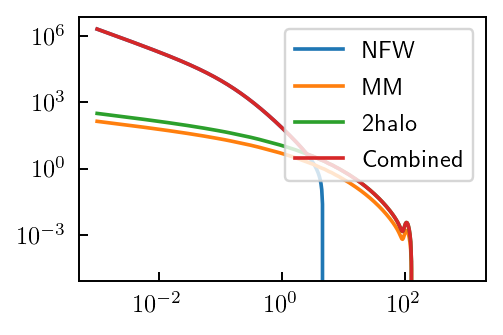

In [11]:
from cluster_toolkit import xi
from cluster_toolkit import bias
#Individual surface density
concentration = 5 #nominal concentration
mass = 1e14
radii = np.logspace(-3,3,500)

#Halo-matter correlation
xi_nfw = xi.xi_nfw_at_R(radii, mass, concentration, Omega_m)
#k and P come from CLASS
xi_mm = xi.xi_mm_at_R(radii, k_ps, Plin)
bias_val = bias.bias_at_M(mass, k_ps, Plin, Omega_m)
xi_2halo = xi.xi_2halo(bias_val, xi_mm)
xi_hm = xi.xi_hm(xi_nfw, xi_2halo)
    
plt.figure(figsize=(3,2))
plt.plot(radii, xi_nfw, label='NFW')
plt.plot(radii, xi_mm, label='MM')
plt.plot(radii, xi_2halo, label='2halo')
plt.plot(radii, xi_hm, label='Combined')
plt.yscale('log'); plt.xscale('log')
plt.legend()
plt.show()


### Testing Halo Mass Function
Testing new code. Build this when come back. 

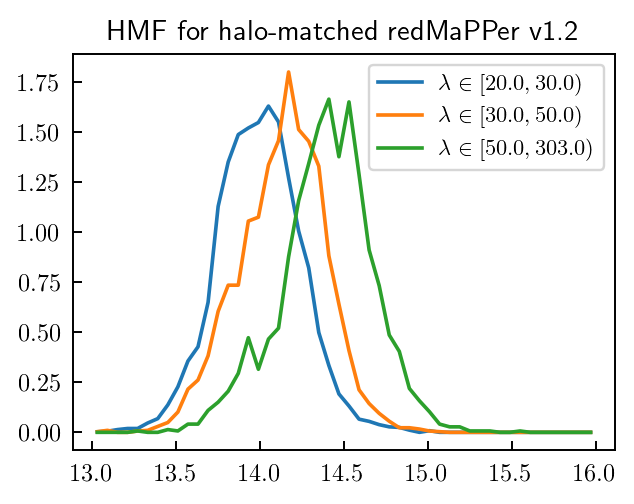

In [12]:
#from tools.halo_mass_template import redMaPPer_hmf

def input_hmf(lnM, lnM_min = 13*np.log(10), lnM_max=16*np.log(10), num_bins=50, lmda_bin=None):
    global lnM200b
    global lnM_lmda_binned
    
    lnM = np.array(lnM) #convert floats into array
    if len(np.shape(lnM))==0:
        lnM = lnM[np.newaxis]    
        
    if lmda_bin == None:
        hmf_lnM = lnM200b
    else:
        hmf_lnM = lnM_lmda_binned[lmda_bin]
    
    lnM_bin_edge = np.linspace(lnM_min, lnM_max, num_bins+1)   #.tolist()
    lnM_bin_cen = lnM_bin_edge[:-1] + (lnM_bin_edge[1] - lnM_bin_edge[0])/2.
    lnM_density = np.histogram(hmf_lnM, lnM_bin_edge, density=True)[0]    
    
    lnM_bin_num = np.array(np.searchsorted(lnM_bin_edge, lnM) - 1)
    lnM_bin_num[np.where(lnM_bin_num == -1)[0]] += 1 #for mass below smallest
    lnM_bin_num[np.where(lnM_bin_num == num_bins)[0]] -= 1 #for mass above highest 

    return lnM_density[lnM_bin_num], lnM_bin_cen

num_bins = 50
lnM_min = 13*np.log(10); lnM_max = 16*np.log(10)
lnM = np.linspace(lnM_min, lnM_max, num_bins)
log10M = lnM/np.log(10)

plt.figure(figsize=(4,3))
for i in range(3):
    dndlnm, cen_bin = input_hmf(lnM, lnM_min=lnM_min, lnM_max=lnM_max, num_bins=num_bins, lmda_bin=i)
    plt.plot(cen_bin/np.log(10), dndlnm*np.log(10), label='$\lambda \in [{0:.1f}, {1:.1f})$'\
             .format(lmda_bins[i][0], lmda_bins[i][1])) #plot in log10 not ln
plt.title('HMF for halo-matched redMaPPer v1.2')
plt.legend(loc = 'best', fontsize=9)
plt.show()

### Individual Surface Density Profiles (for testing)

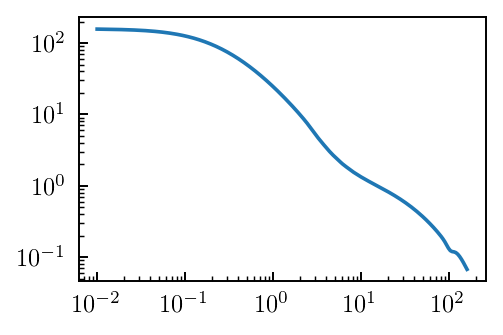

In [13]:
from cluster_toolkit import deltasigma
mass = 1e14 #Msun/h
concentration = 5 #arbitrary
r = np.logspace(-2,2.2,200)
#radii = np.logspace(-3,3,500) #radii has to match the radii used for calculating xi_hm
#halo-matter correlation calculated above
Sigma = deltasigma.Sigma_at_R(r, radii, xi_hm, mass, concentration, Omega_m)
DS_bar = deltasigma.DeltaSigma_at_R(r, r, Sigma, mass, concentration, Omega_m)
plt.figure(figsize=(3,2))
plt.plot(r, DS_bar)
plt.yscale('log'); 
plt.xscale('log')
plt.show()

### Stacked Lensing Profiles
#### TODO! Need to adapt the concentration to e.g. Tinker to match concentration-mass relation

In [14]:
from cluster_toolkit import xi
from cluster_toolkit import bias
from scipy.integrate import nquad
from time import time
from cluster_toolkit import deltasigma


'''
Integrand for stacked DS profile across richness bins. See section 5.2 triaxiality paper.
Sigma profile of halo using nfw for nominal concentration of 5. 

lnM: Mass in log Msun/h
lnl log(richness)
mu=cosi from 0 to 1
lmda_bin = 0,1,2 the lambda bin to calculate halo mass function for matched halos
z: redshift
r = array of projected radius in Mpc/h
Orientation: True for orientation dependent model, False for w/o dependence. Need to input mu nonetheless.

Outputs:
the integrand for stacked DS for a range of projected sky radius
'''
def stacked_DS_integrand(lnM, lnl, mu, z, r,  radii, xi_hm, concentration=5, lmda_bin=0, orientation=True):
    global k_ps
    global Plin
    #r = np.logspace(-2,2,100)
    #Shift in richness-mass relationship
    mass =np.exp(lnM)
    
    if orientation == True:
        prob_lnl = prob_lambda(lnl, lnM, mu=mu)
    else:
        prob_lnl = prob_lambda(lnl, lnM, mu=None)
    
    #Individual surface density
    #concentration = 5 #nominal concentration

    x = np.log(r)
    Sigma = deltasigma.Sigma_at_R(r, radii, xi_hm, mass, concentration, Omega_m)
    DS_bar = deltasigma.DeltaSigma_at_R(r, r, Sigma, mass, concentration, Omega_m)
    
    if orientation:
        DS_mu = np.exp(lnDS_ratio(mu, x, z=z, m=mass)) * DS_bar
    else:
        DS_mu = DS_bar
    #spl_DS_mu = spline(r, DS_mu, s=0.0)
    
    #Calculating the mass function
    dndlnm, cen_bin = input_hmf(lnM, lmda_bin=lmda_bin)
    
    return prob_lnl*DS_mu*dndlnm

## Computing stacked DS

To do: Compute the stacked profile by mass and redshift. Done for a single richness bin. 
Then: Compute bin by richness, for single mass/redshift bin. 

In [15]:
#ds_tplt_dir = home_dir()+'output/deltasigma/'
ds_tplt_file = ds_tplt_dir + 'fit_cauchy_sqr_errorbar.dat'
ds_tplt = np.genfromtxt(ds_tplt_file, unpack=True)
ds_tplt = ds_tplt.reshape(12, 4, 4)

z_min = ds_tplt[0]; z_max = ds_tplt[1]
m_min = ds_tplt[2]; m_max = ds_tplt[3]

In [16]:
#Build Tabulated integral

num_int = 10 #Switch to 50 for full run
lnM_min = min(lnM200b); lnM_max = max(lnM200b)
lnM_range = np.log(10)*np.linspace(lnM_min,lnM_max, num_int); dlnM = lnM_range[1]- lnM_range[0]
mu_range = np.linspace(0.,1.,num_int); dmu = mu_range[1]- mu_range[0]

r_num = 50 #Switch to 200 for full run.
#(4,4,3) for the mass, redshift, lambda bins
DS_stacked_cosi = np.zeros((4, 4, 3, r_num)) #orientation dependence #Change back to [len(c_arr), len(lmda_bins), r_num]
DS_stacked_avg = np.zeros((4, 4, 3, r_num)) #no orientation dependence
r = np.logspace(-2,2,r_num)  

#Arrays to loop through
concentration = 5

for p, z_cur in enumerate(z_max[:,0]):
    print "\nredshift range is [{0:.2g}, {1:.2g})".format(z_min[p,0], z_max[p,0])
    
    for q, m_cur in enumerate(m_max[0,:]):
        print "mass range is [{0:.2g}, {1:.2g})".format(m_min[0,q], m_max[0,q])
        lnM_range = np.log(np.linspace(m_min[0,q],m_max[0,q],num_int)); dlnM = lnM_range[1]- lnM_range[0]
        
        for l in range(len(lmda_bins)):
            print "Lambda bin ", lmda_bins[l]
            lnl_range = np.log(np.linspace(lmda_bins[l][0], lmda_bins[l][1], num_int)); dlnl = lnl_range[1]- lnl_range[0]    
            
            for i, ilnM in enumerate(lnM_range):
                #Calculate halo-matter correlation for different mass bins
                mass = np.exp(ilnM)
                radii = np.logspace(-3,3,200)
                #concentration = c_cur #nominal concentration
                xi_nfw = xi.xi_nfw_at_R(radii, mass, concentration, Omega_m)
                #Assume that k and P come from somewhere, e.g. CAMB or CLASS
                xi_mm = xi.xi_mm_at_R(radii, k_ps, Plin)
                hbias = bias.bias_at_M(mass, k_ps, Plin, Omega_m)
                xi_2halo = xi.xi_2halo(hbias, xi_mm)
                xi_hm = xi.xi_hm(xi_nfw, xi_2halo)

                for j, jlnl in enumerate(lnl_range):
                    for k, kmu in enumerate(mu_range):       
                        #Calculate stacked density
                        DS_stacked_cosi[q,p] += stacked_DS_integrand(ilnM, jlnl, kmu, z_cur, r, radii, xi_hm, concentration=concentration, lmda_bin=l, orientation=True)
                        DS_stacked_avg[q,p] += stacked_DS_integrand(ilnM, jlnl, kmu, z_cur, r, radii, xi_hm, concentration=concentration, lmda_bin=l, orientation=False)

            DS_stacked_cosi[p,q,l] *= dlnM * dlnl * dmu 
            DS_stacked_avg[p,q,l] *= dlnM * dlnl * dmu 


redshift range is [0, 0.34)
mass range is [5e+13, 1e+14)
Lambda bin  [20, 30]
Lambda bin  [30, 50]
Lambda bin  [50, 303.0442810058594]
mass range is [1e+14, 2e+14)
Lambda bin  [20, 30]
Lambda bin  [30, 50]
Lambda bin  [50, 303.0442810058594]
mass range is [2e+14, 4e+14)
Lambda bin  [20, 30]
Lambda bin  [30, 50]
Lambda bin  [50, 303.0442810058594]
mass range is [4e+14, 1e+16)
Lambda bin  [20, 30]
Lambda bin  [30, 50]
Lambda bin  [50, 303.0442810058594]

redshift range is [0.34, 0.5)
mass range is [5e+13, 1e+14)
Lambda bin  [20, 30]
Lambda bin  [30, 50]
Lambda bin  [50, 303.0442810058594]
mass range is [1e+14, 2e+14)
Lambda bin  [20, 30]
Lambda bin  [30, 50]
Lambda bin  [50, 303.0442810058594]
mass range is [2e+14, 4e+14)
Lambda bin  [20, 30]
Lambda bin  [30, 50]
Lambda bin  [50, 303.0442810058594]
mass range is [4e+14, 1e+16)
Lambda bin  [20, 30]
Lambda bin  [30, 50]
Lambda bin  [50, 303.0442810058594]

redshift range is [0.5, 0.7)
mass range is [5e+13, 1e+14)
Lambda bin  [20, 30]
Lamb

### Plotting

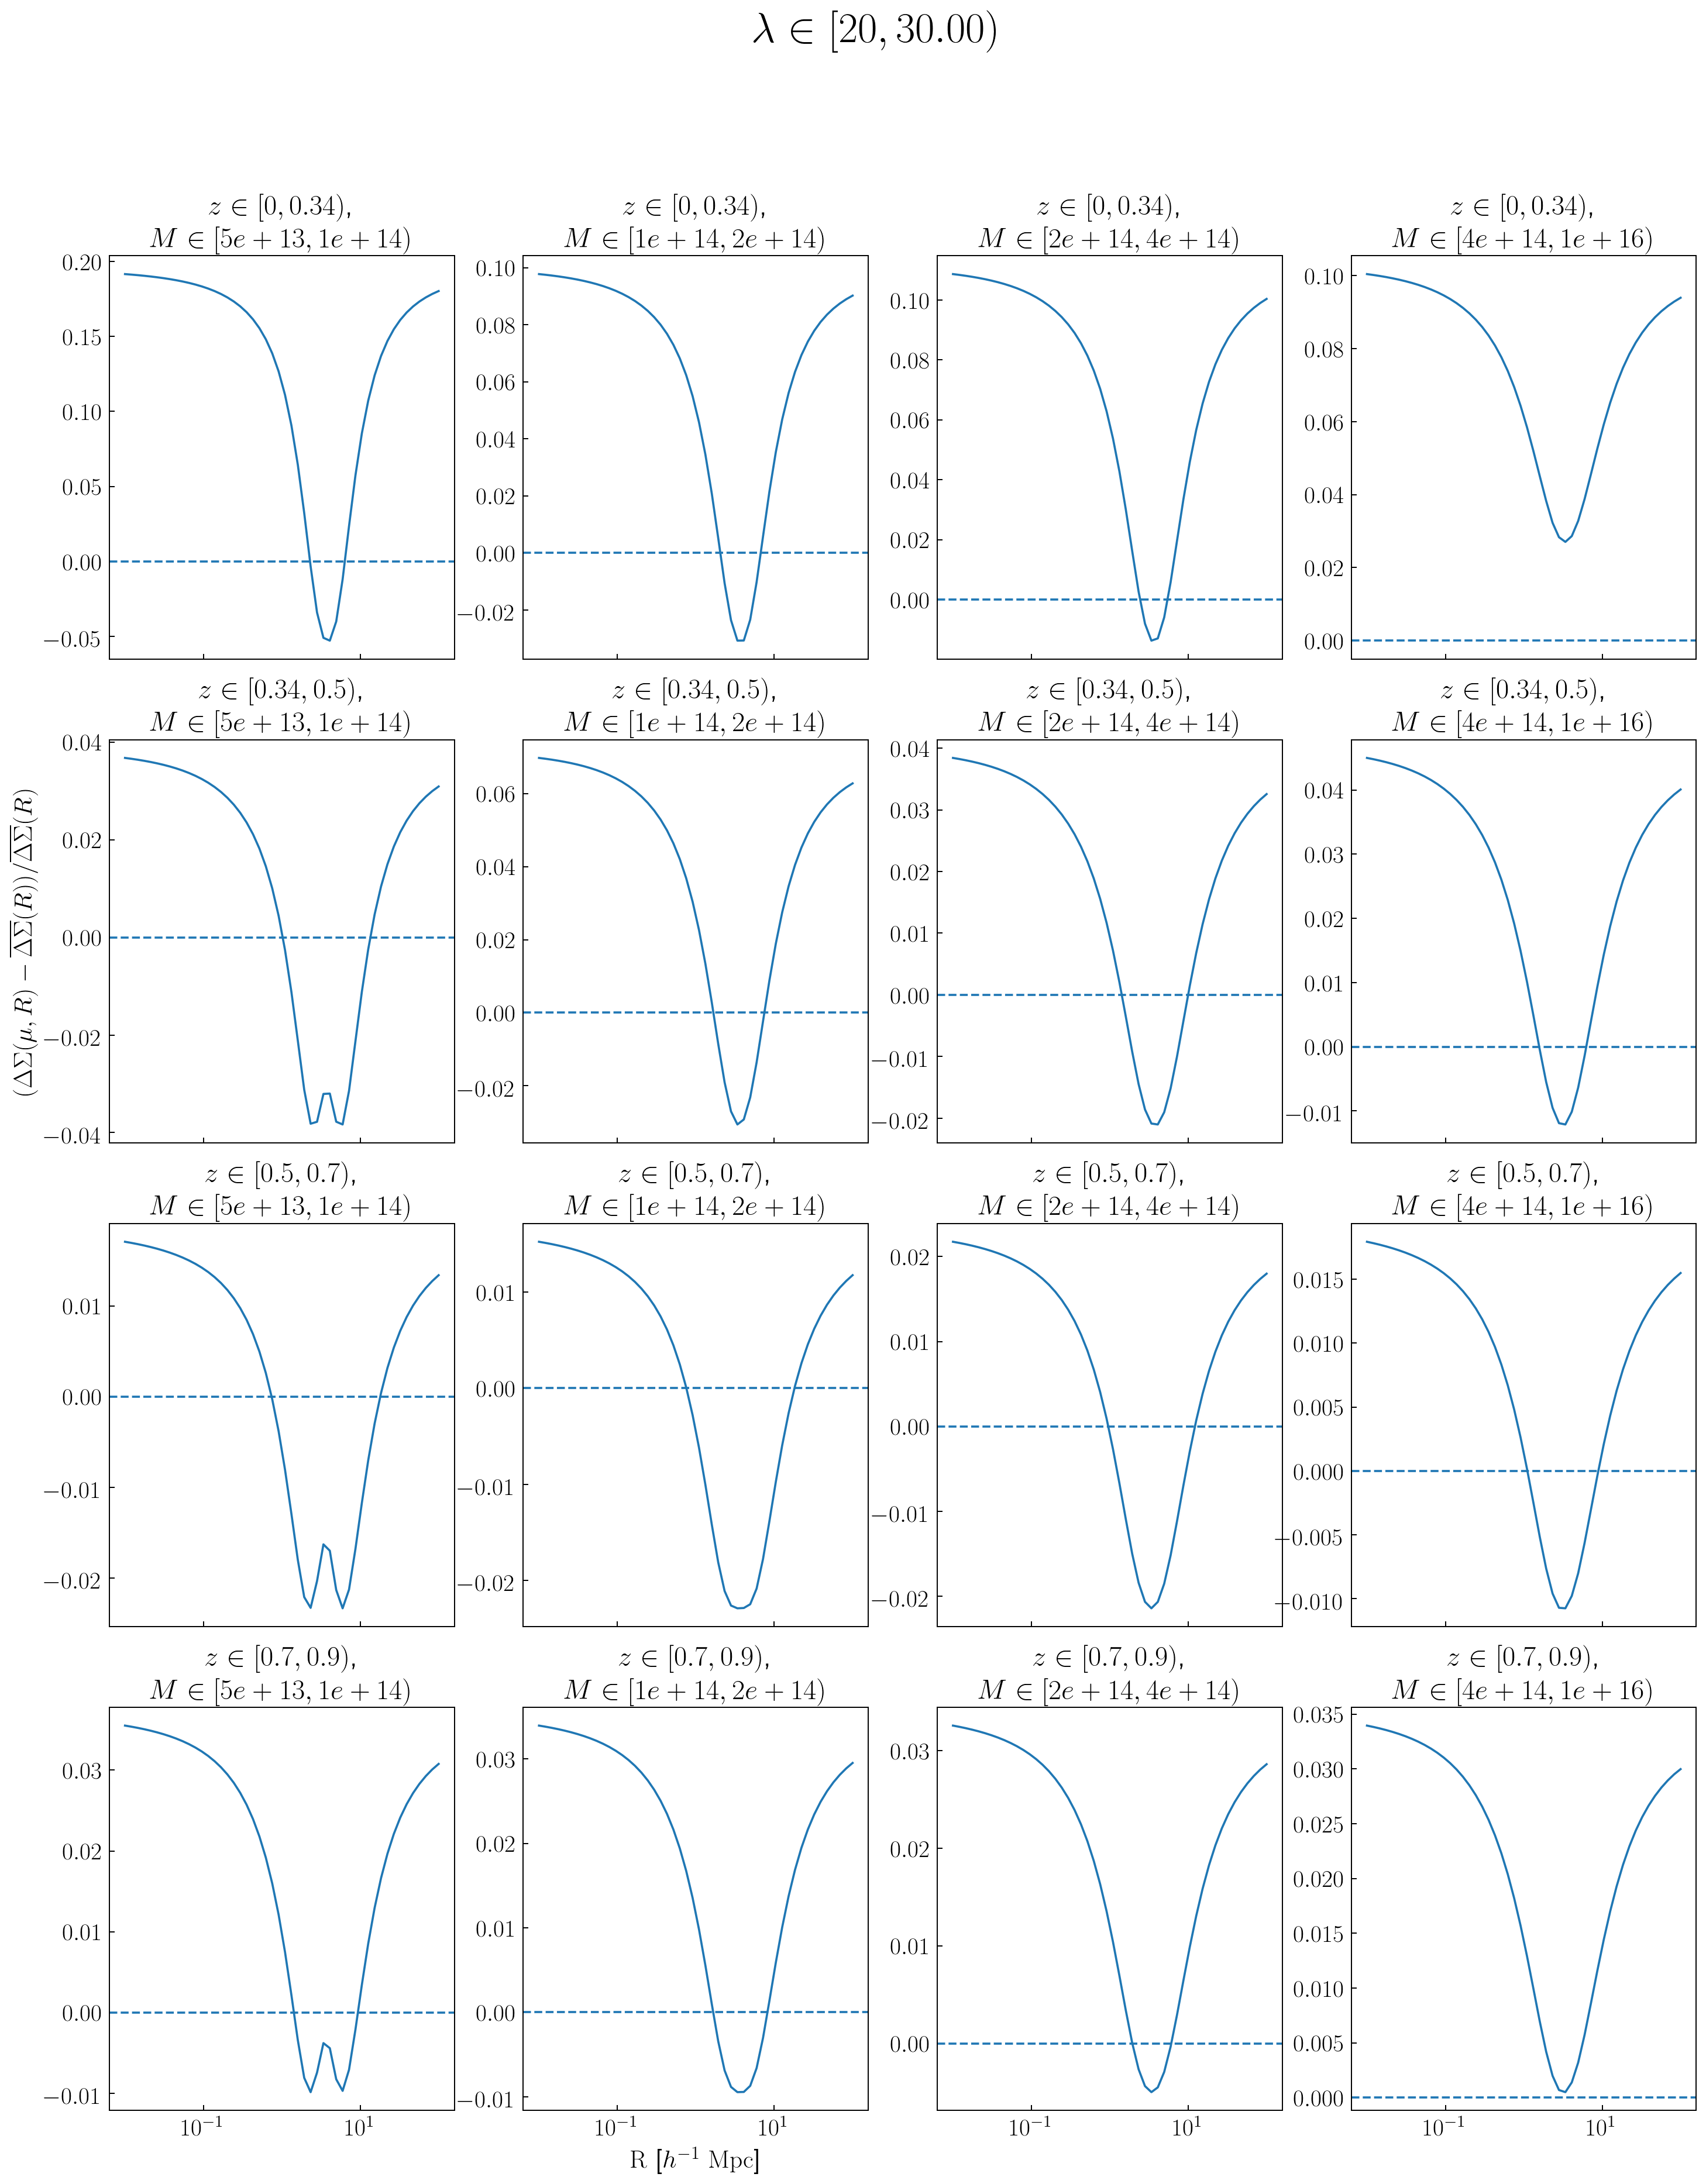

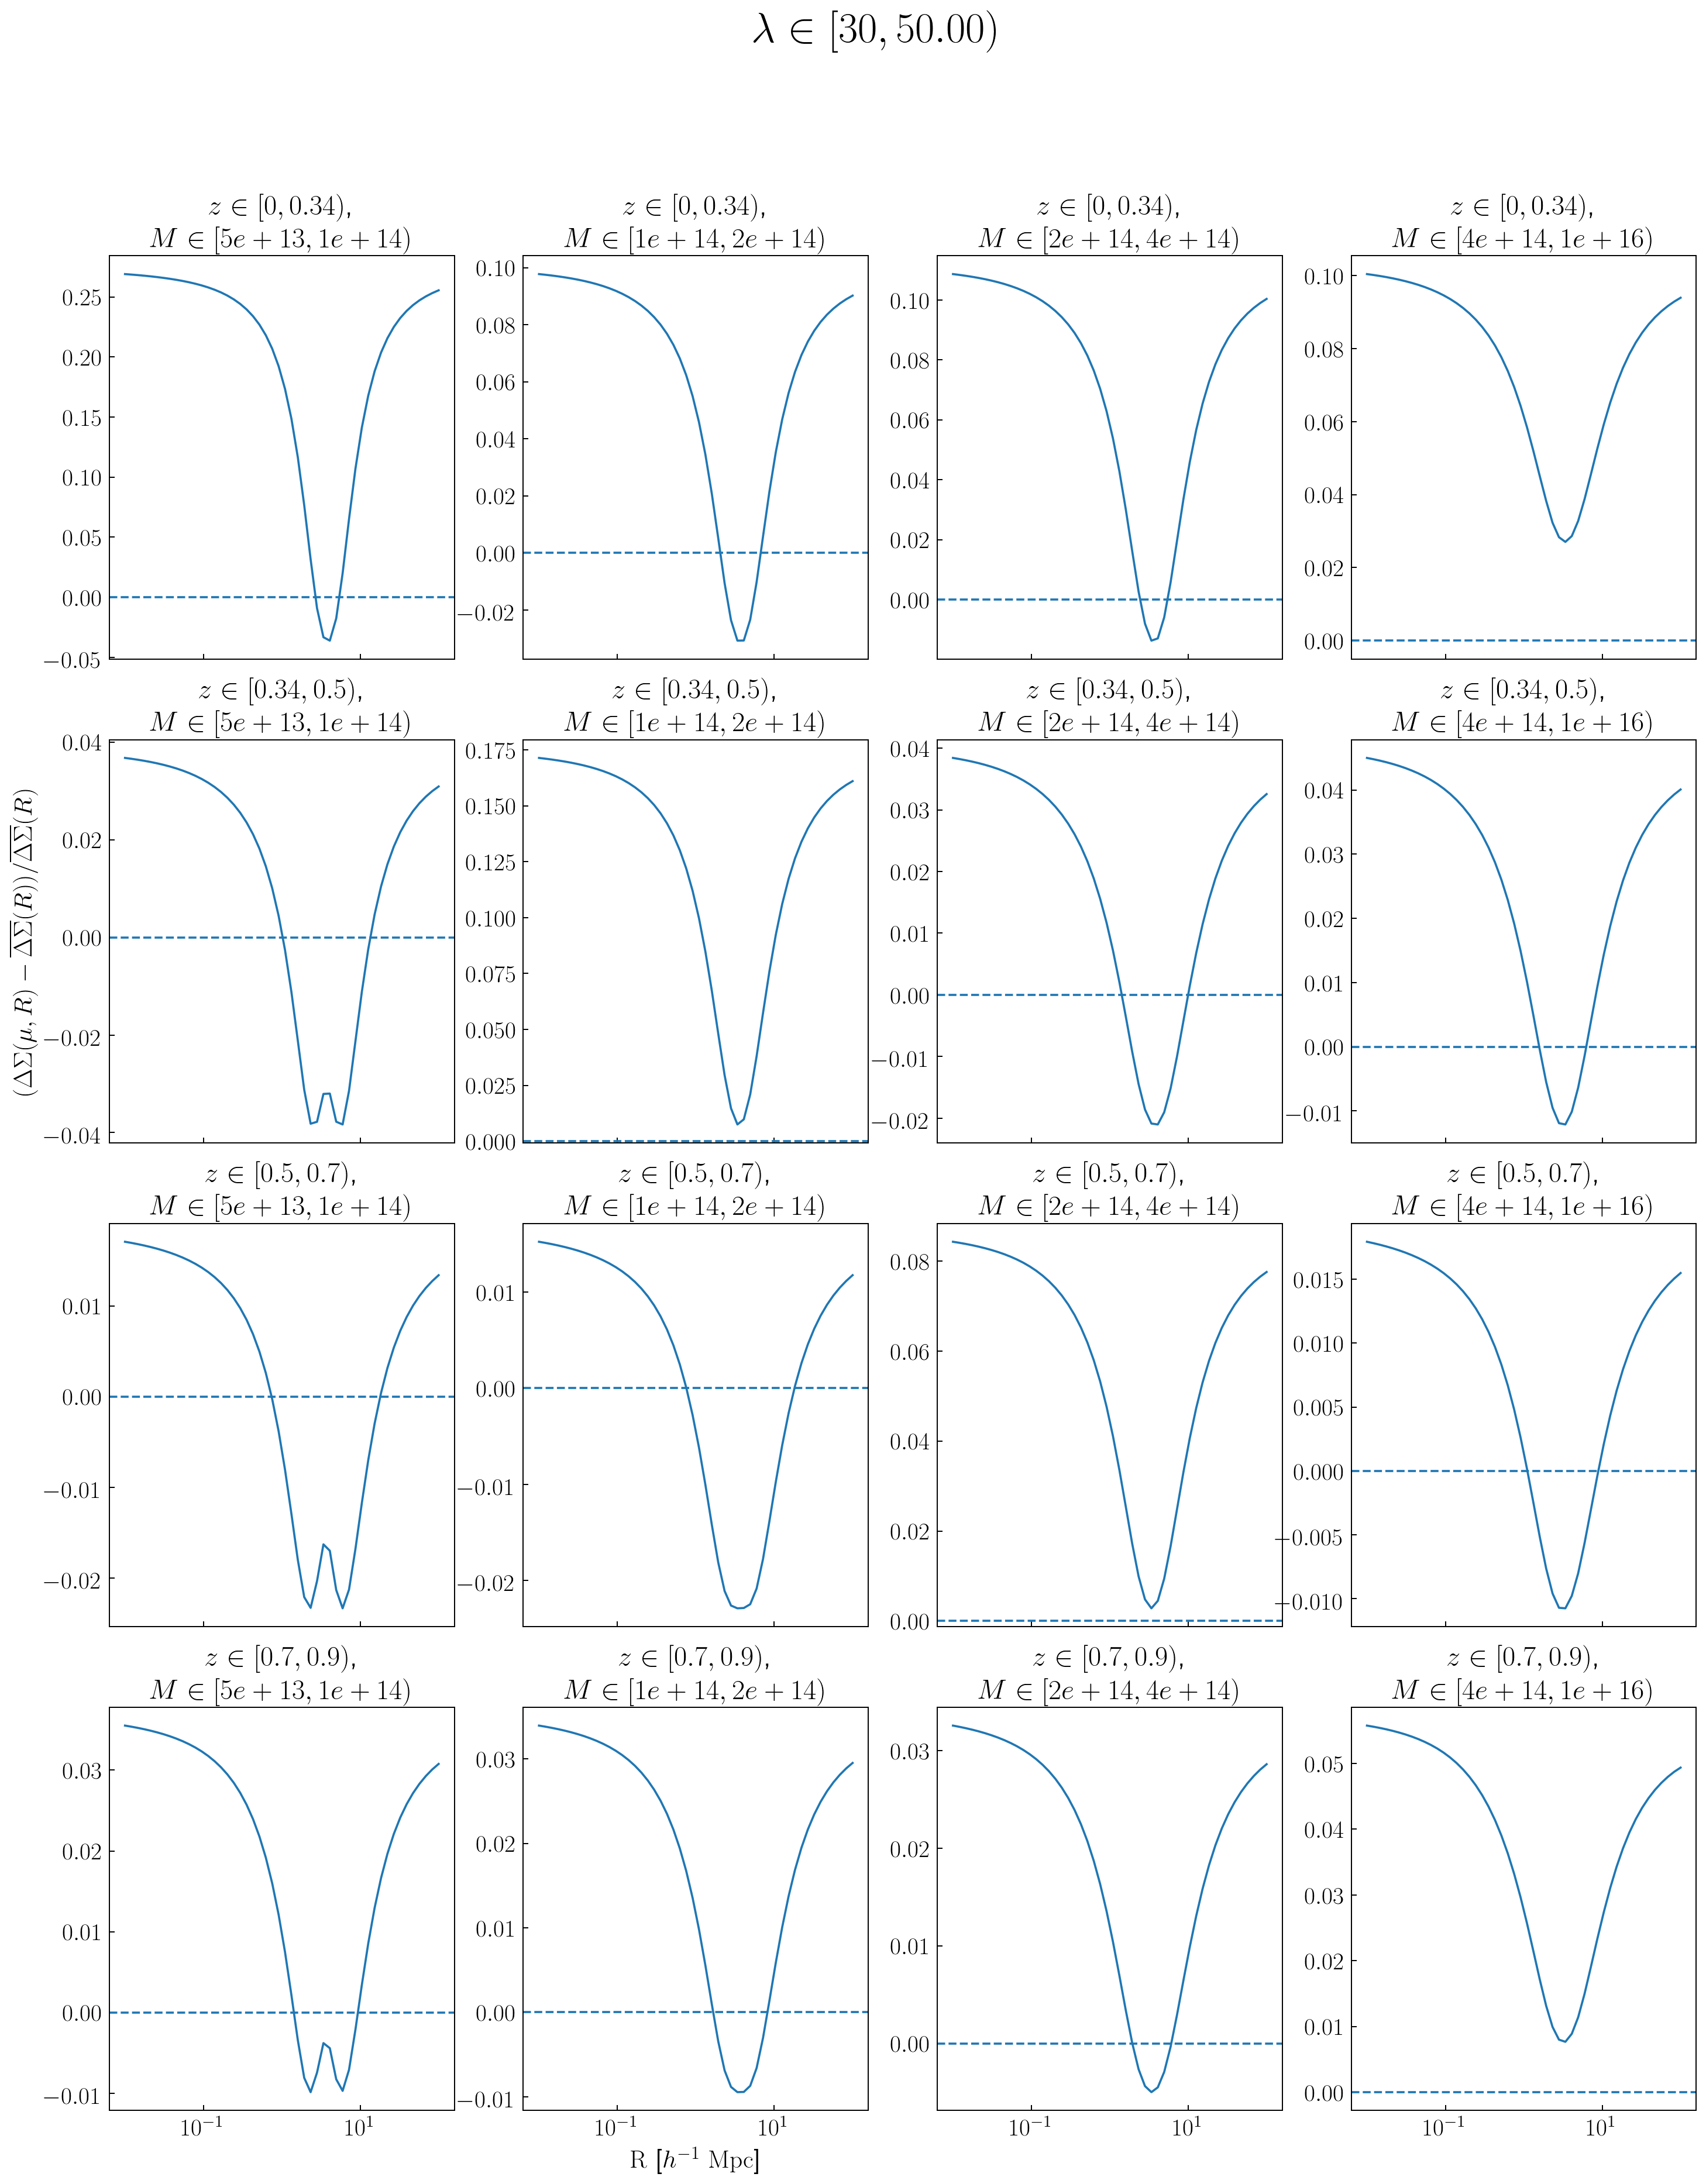

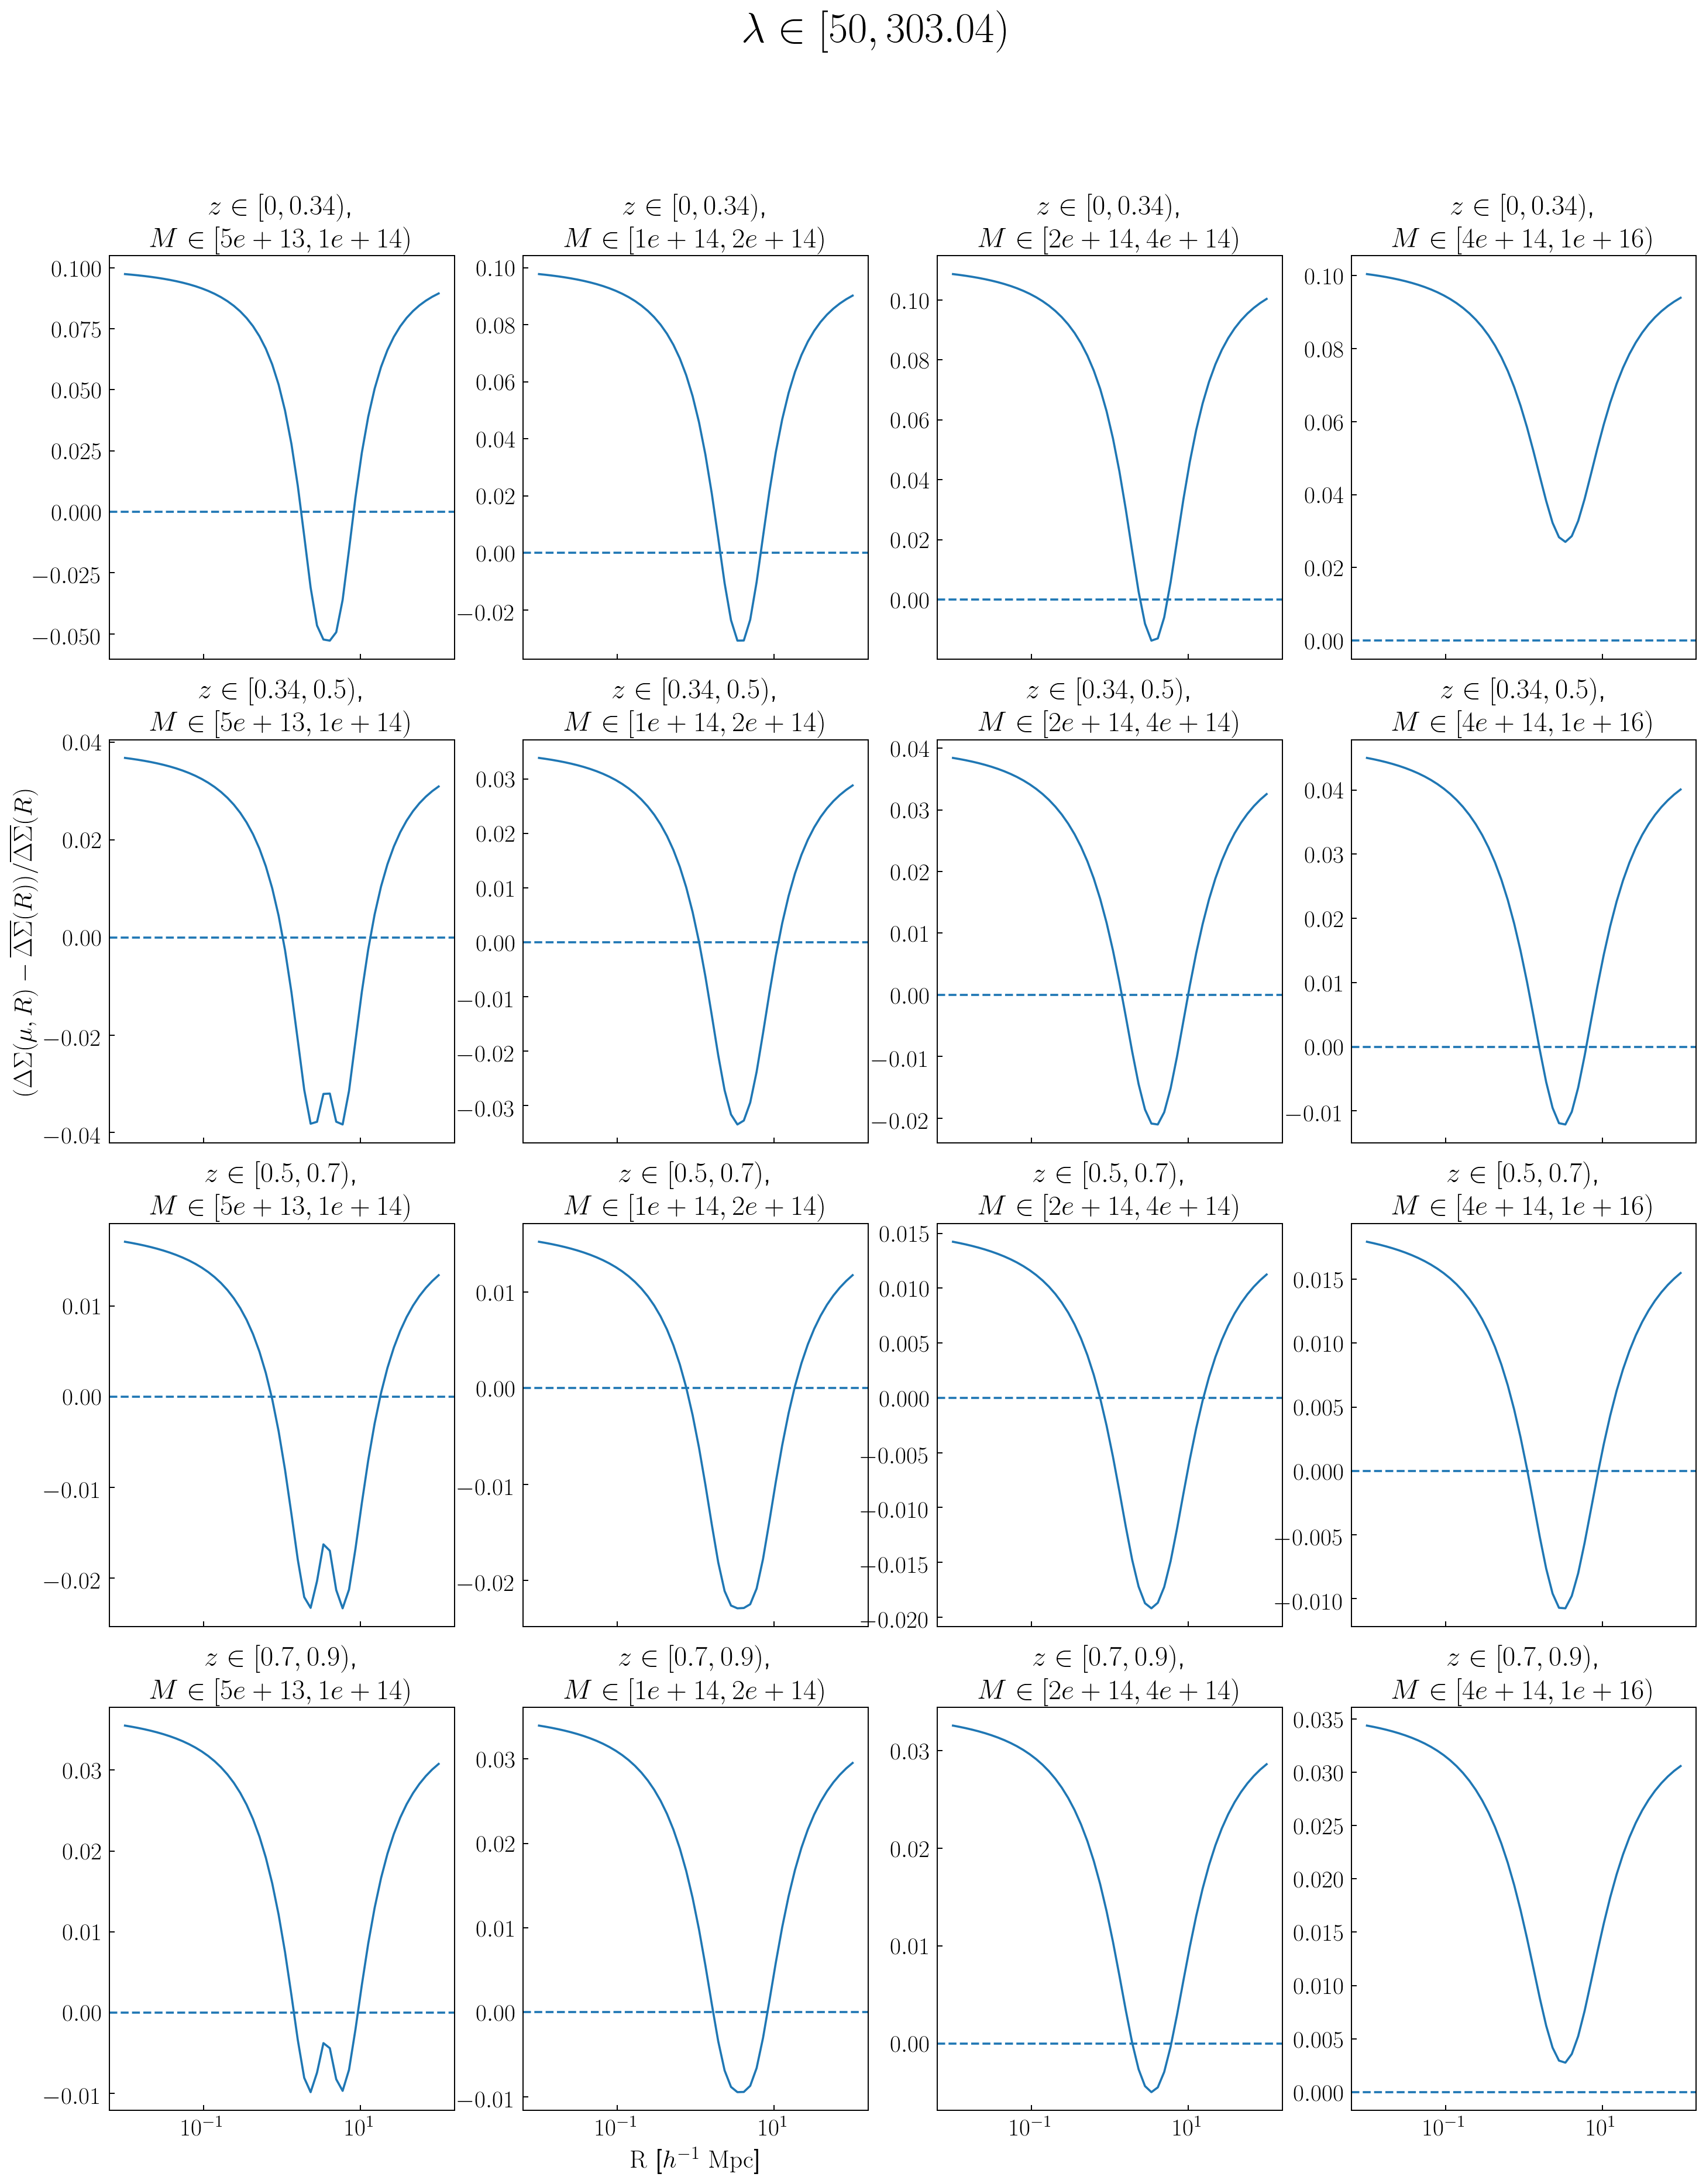

In [21]:
#Plot all and see what the difference is. Are all above 0.0 or any below 0.0. Can we disregard any based on noise?
for k in range(len(lmda_bins)):
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,24), sharex='all')
    fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
    for i, z_cur in enumerate(z_max[:,0]):
           #print "\nredshift range is [{0:.2g}, {1:.2g})".format(z_min[p,0], z_max[p,0])

        for j, m_cur in enumerate(m_max[0,:]):
            #print "mass range is [{0:.2g}, {1:.2g})".format(m_min[0,q], m_max[0,q])
            DS_stacked_fracdiff = (DS_stacked_cosi[i,j,k]-DS_stacked_avg[i,j,k])/DS_stacked_avg[i,j,k]

            ax[i,j].plot(r, DS_stacked_fracdiff)
            ax[i,j].tick_params(axis='both', which='major', labelsize=17)
            ax[i,j].set_title('$z \in [{0:.2g}, {1:.2g})$, \n $M \in [{2:.2g}, {3:.2g})$'\
                              .format(z_min[i,0], z_max[i,0], m_min[0,j], m_max[0,j],), fontsize=20)
            ax[i,j].axhline(0.0, linestyle='--')
           
    ax[1,0].set_xscale('log'); #axs[1].set_yscale('log')
    ax[1,0].set_ylabel(r"$\big(\Delta\Sigma(\mu, R)-\overline{\Delta\Sigma}(R)\big)/\overline{\Delta\Sigma}(R)$", fontsize=18)
    ax[3,1].set_xlabel(r"\textrm{R} [$h^{-1}~$\textrm{Mpc}]"  , fontsize=18)
    plt.show()
#ax[0,0].legend(loc='upper left', fontsize=19)


## Save the stacked DS and $\delta\Delta\Sigma$ as record arrays.

In [22]:
fracdiff = (DS_stacked_cosi-DS_stacked_avg)/DS_stacked_avg

In [23]:
#Save onto record array. First thing to do in the morning. 
import pickle
#When come back think of better ways of storing it to make mass, redshift and lambda bins more obvious. 

pickle.dump(DS_stacked_cosi, open('DS_stacked_cosi.p', "wb"))
pickle.dump(DS_stacked_avg, open('DS_stacked_avg.p', "wb"))
pickle.dump(fracdiff, open('DS_stacked_fracdiff.p', "wb"))